## Water Quality Analysis and Potability Prediction

This notebook presents a machine learning approach to predict water potability based on various quality metrics. We explore the impact of feature selection on model performance using a Histogram-based Gradient Boosting Classification model.


### 1. Setup and Data Loading


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(42)


In [9]:
graphs_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'graphs')
if not os.path.exists(graphs_dir):
    os.makedirs(graphs_dir)
    print(f"Created directory: {graphs_dir}")
else:
    print(f"Directory already exists: {graphs_dir}")


Directory already exists: D:\Development\Personal\water_quality_analysis\graphs


#### 1.1 Load and Examine the Dataset


In [10]:
df = pd.read_csv('./data/water_potability.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows of the dataset:")
display(df.head())

print("\nMissing values in each column:")
print(df.isnull().sum())

print("\nBasic statistics:")
display(df.describe())


Dataset shape: (3276, 10)

First few rows of the dataset:


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0



Missing values in each column:
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Basic statistics:


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


#### 1.2 Data Visualization

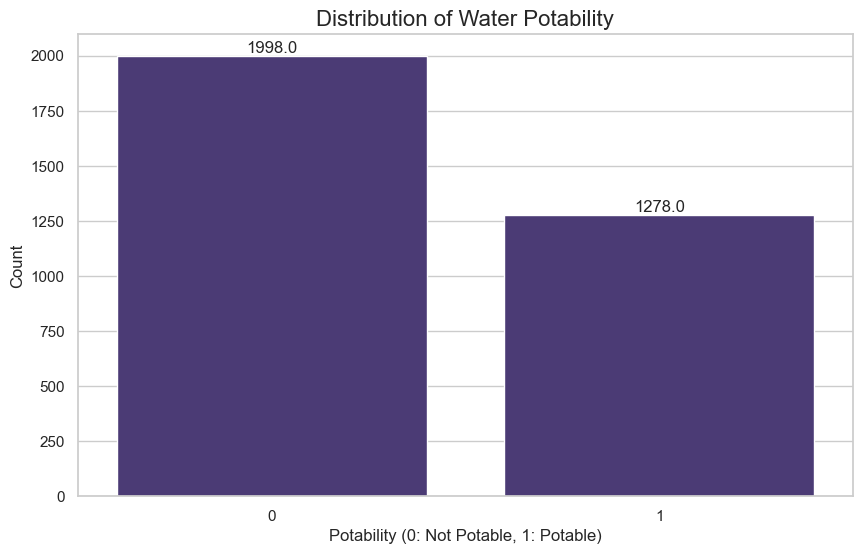

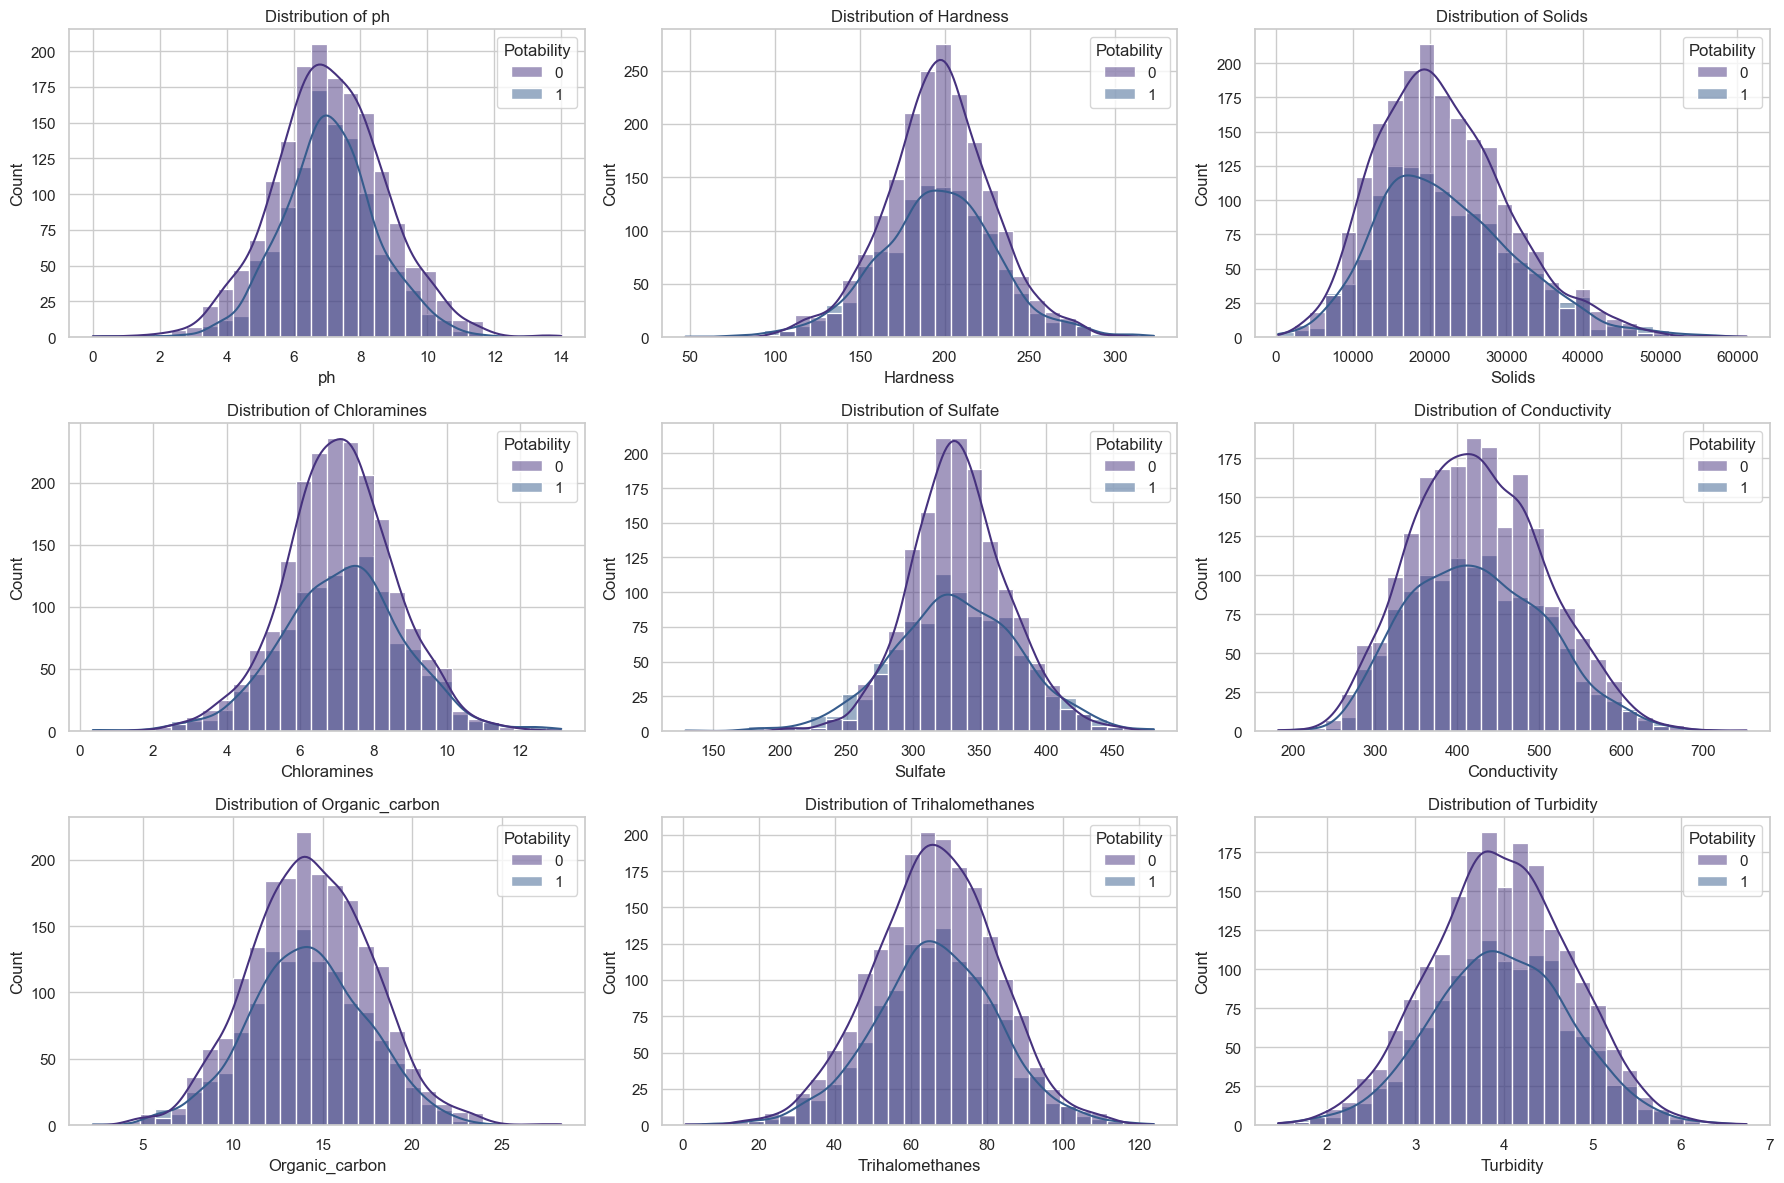

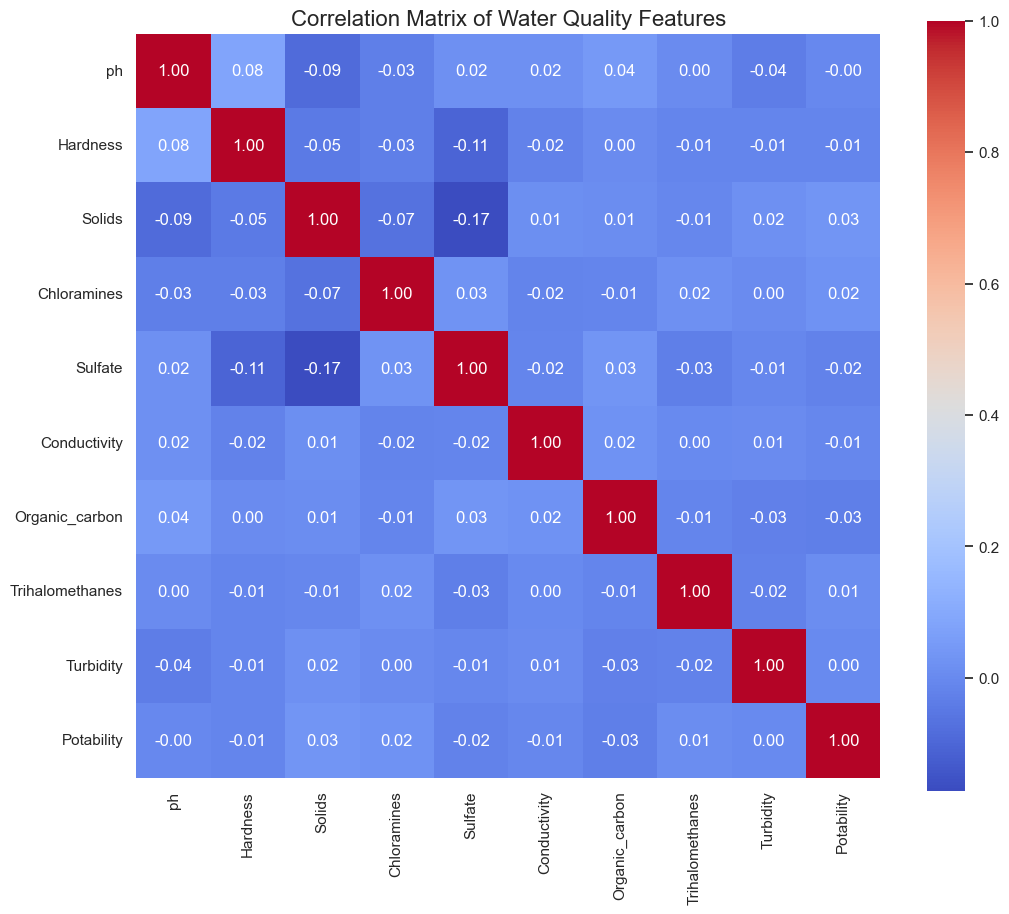

In [11]:
sns.set_theme(style="whitegrid", palette="viridis")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Potability', data=df)
ax.set_title('Distribution of Water Potability', fontsize=16)
ax.set_xlabel('Potability (0: Not Potable, 1: Potable)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=12)
plt.savefig(os.path.join(graphs_dir, 'potability_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(18, 12))
for i, column in enumerate(df.drop('Potability', axis=1).columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df, x=column, hue='Potability', kde=True, bins=30)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir, 'feature_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Water Quality Features', fontsize=16)
plt.savefig(os.path.join(graphs_dir, 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()


### 2. Experiment Setup and Model Training

In [12]:
def run_experiment(df, drop_columns):
    df2 = df.copy()
    title = "Dropped 'Organic_carbon' & 'Trihalomethanes'" if drop_columns else "All columns included"
    if drop_columns:
        df2 = df2.drop(['Organic_carbon', 'Trihalomethanes'], axis=1)
    df2 = df2.dropna()

    X = df2.drop('Potability', axis=1)
    y = df2['Potability']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model = HistGradientBoostingClassifier(random_state=42)
    param_dist = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_iter': [100, 200, 300],
        'max_leaf_nodes': [15, 31, 63, None],
        'min_samples_leaf': [20, 30, 50],
        'l2_regularization': [0.0, 0.1, 0.5]
    }
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\n=== {title} ===")
    print("Best hyperparameters:", search.best_params_)
    print(f"Test accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'title': title,
        'best_params': search.best_params_,
        'accuracy': acc,
        'report': report,
        'confusion_matrix': conf_matrix,
        'model': best_model,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred
    }


### 3. Experiment Execution

We'll run two experiments:
1. With 'Organic_carbon' and 'Trihalomethanes' columns dropped
2. With all columns included


In [13]:
results = {}
results['dropped'] = run_experiment(df, drop_columns=True)
results['all'] = run_experiment(df, drop_columns=False)


Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== Dropped 'Organic_carbon' & 'Trihalomethanes' ===
Best hyperparameters: {'min_samples_leaf': 20, 'max_leaf_nodes': 31, 'max_iter': 100, 'learning_rate': 0.05, 'l2_regularization': 0.0}
Test accuracy: 0.7028
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       254
           1       0.70      0.46      0.55       170

    accuracy                           0.70       424
   macro avg       0.70      0.66      0.67       424
weighted avg       0.70      0.70      0.69       424

Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== All columns included ===
Best hyperparameters: {'min_samples_leaf': 20, 'max_leaf_nodes': None, 'max_iter': 100, 'learning_rate': 0.01, 'l2_regularization': 0.0}
Test accuracy: 0.6725
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       

### 4. Results Analysis and Visualization


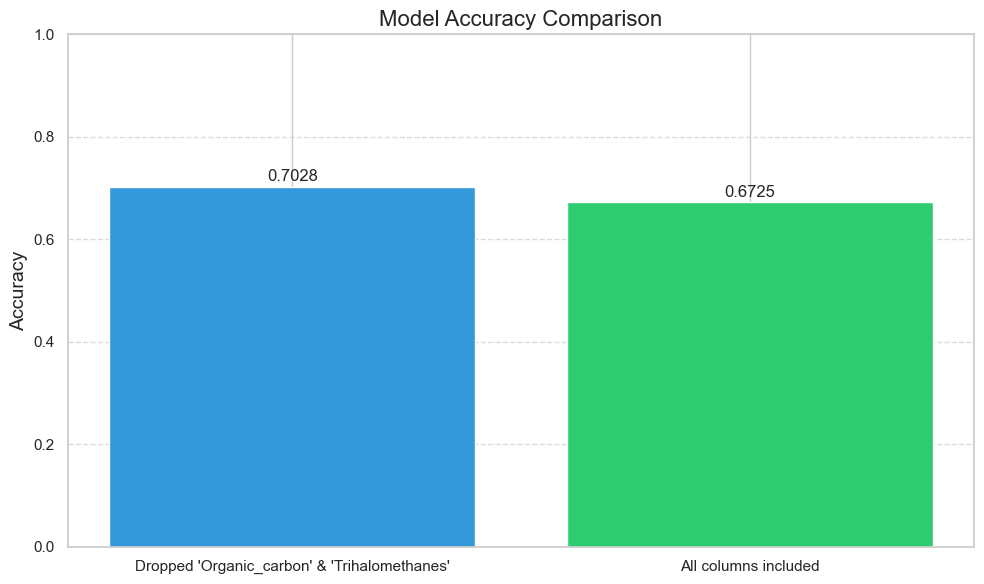

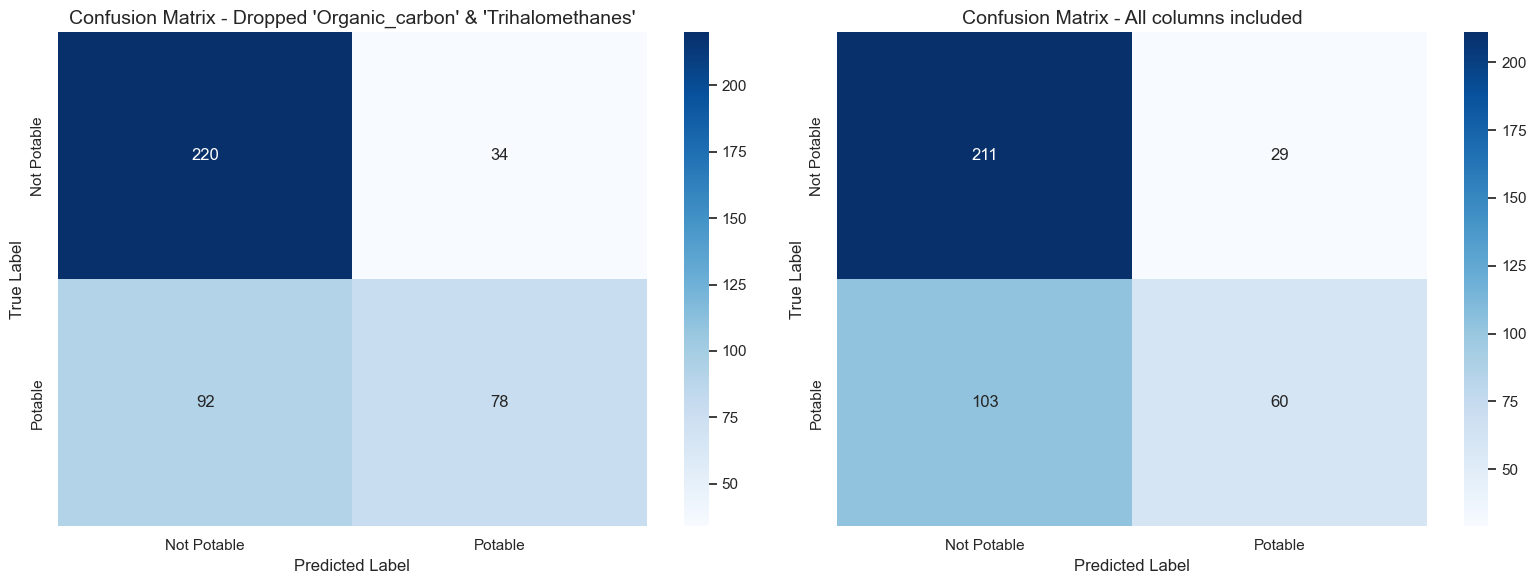

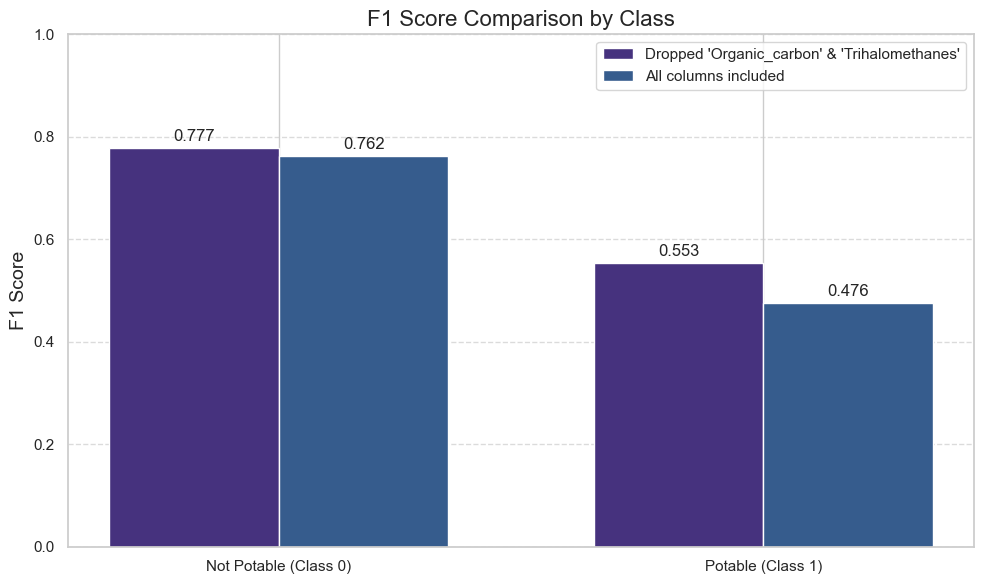

In [14]:
accuracies = [results['dropped']['accuracy'], results['all']['accuracy']]
experiment_names = [results['dropped']['title'], results['all']['title']]

plt.figure(figsize=(10, 6))
bars = plt.bar(experiment_names, accuracies, color=['#3498db', '#2ecc71'])
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.4f}', ha='center', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir, 'model_accuracy_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
titles = [results['dropped']['title'], results['all']['title']]

for i, (key, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {titles[i]}', fontsize=14)
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('True Label', fontsize=12)
    axes[i].set_xticklabels(['Not Potable', 'Potable'])
    axes[i].set_yticklabels(['Not Potable', 'Potable'])
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()

f1_scores = {
    'dropped': [
        results['dropped']['report']['0']['f1-score'],
        results['dropped']['report']['1']['f1-score']
    ],
    'all': [
        results['all']['report']['0']['f1-score'],
        results['all']['report']['1']['f1-score']
    ]
}

x = np.arange(2)
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, f1_scores['dropped'], width, label=results['dropped']['title'])
rects2 = ax.bar(x + width/2, f1_scores['all'], width, label=results['all']['title'])

ax.set_title('F1 Score Comparison by Class', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(['Not Potable (Class 0)', 'Potable (Class 1)'])
ax.set_ylabel('F1 Score', fontsize=14)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.savefig(os.path.join(graphs_dir, 'f1_score_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
